# Tutorial Auto-Tagging using different front-end/ different architecture

- date: 2024-10-10
- author: geoffroy.peeters@telecom-paris.fr

This notebook was created for the tutorial held at ISMIR-2024 "Deep-Learning 101 for Audio-based Music Information Retrieval".
It illustrates the use of various deep-learning bricks to solve the task of "Auto-Tagging".

Part of the code is based on 
- SincNet model: https://github.com/mravanelli/SincNet/blob/master/dnn_models.py 

In [1]:
do_deploy = False

In [2]:
if do_deploy:
    !git clone https://github.com/geoffroypeeters/DL101forMIR_notebook.git
    %cd DL101forMIR_notebook
    !ls

## Import packages

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
#import torchaudio
from torch.utils.data import Dataset
import torch.optim as optim
import torchsummary

! pip install lightning --quiet
import lightning.pytorch as pl
from lightning.pytorch.callbacks import Callback
from lightning.pytorch.callbacks import EarlyStopping, ModelCheckpoint

! pip install wandb --quiet
import wandb
from pytorch_lightning.loggers import WandbLogger

import json
import yaml
import h5py
import pprint as pp
from tqdm import tqdm
import datetime
from multiprocessing import Pool
import os

import librosa
import numpy as np
import matplotlib.pyplot as plt
import feature
plt.rcParams['figure.figsize'] = [15, 10]
import IPython.display

# -----------------------------
import model_factory 
import importlib
importlib.reload(model_factory) 

from argparse import Namespace
! pip install munch --quiet
from munch import munchify

## Parameters

In [4]:
if do_deploy:
    import urllib.request
    pre = 'https://drive.google.com/uc?export=download&id='
    urllib.request.urlretrieve('https://perso.telecom-paristech.fr/gpeeters/tuto_DL101forMIR/gtzan-genre_audio.hdf5.zip', 'gtzan-genre_audio.hdf5.zip')
    ! unzip ./gtzan-genre_audio.hdf5.zip
    urllib.request.urlretrieve('https://perso.telecom-paristech.fr/gpeeters/tuto_DL101forMIR/gtzan-genre.pyjama', 'gtzan-genre.pyjama')

In [5]:
if do_deploy:
    ROOT = './'
else:
    ROOT = '/tsi/data_doctorants/gpeeters/_data/'

#base, problem, annot_key = 'gtzan-genre', 'multiclass', 'genre'
base, problem, annot_key = 'mtt', 'multilabel', 'tag'
hdf5_audio_file = f'{ROOT}/{base}_audio.hdf5'
pyjama_annot_file = f'{ROOT}/{base}.pyjama'


do_feature = 'lms'#, 'waveform', 'lms'
param_lms = Namespace()
param_lms.nb_band = 128
param_lms.L_n = 2048
param_lms.STEP_n = 1024

param_patch = Namespace()
param_model = Namespace()
if do_feature == 'waveform':
    param_patch.L_frame = 3200
    param_model.n_in = 1
elif do_feature == 'lms':
    param_patch.L_frame = 64
    param_model.n_in = param_lms.nb_band
param_patch.STEP_frame = int(param_patch.L_frame/2)

param_model.T_in = param_patch.L_frame
param_model.n_out = 10
param_model.batch_size = 128
param_model.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

param_lightning = Namespace()
param_lightning.max_epochs = 500
param_lightning.dirpath='my_model/'
param_lightning.filename='best_model'


## Dataloader

### Test loading pyjama/hdf5

In [6]:
def f_get_labelname_dict(data_d, annot_key):
    """
    description:
        provides the dictionary of labelname used in a given corpus
    """
    labelname_dict_l = []
    for entry in data_d['collection']['entry']:
        for annot in entry[annot_key]:
            labelname_dict_l.append(annot['value'])
    labelname_dict_l = list(set(labelname_dict_l))
    return sorted(labelname_dict_l)

def f_get_groundtruth_item(entry, annot_key, labelname_dict_l, problem):
    """
    description:
        map a label (or a list of labels) to a ground-truth
    """
    if problem=='multiclass':
        annot = entry[annot_key][0]
        idx_label = labelname_dict_l.index(annot['value'])
    elif problem=='multilabel':
        idx_label = np.zeros(len(labelname_dict_l))
        for annot in entry[annot_key]:
            pos = labelname_dict_l.index(annot['value'])
            idx_label[ pos ] = 1
    return idx_label


In [8]:
with open(pyjama_annot_file, encoding = "utf-8") as json_fid:
    data_d = json.load(json_fid)
entry_l = data_d['collection']['entry']
audiofile_l = [entry['filepath'][0]['value'] for entry in entry_l]
print(f'number of audio: {len(audiofile_l)}')
pp.pprint(audiofile_l[:5])


labelname_dict_l = f_get_labelname_dict(data_d, annot_key)
print(f'number of tags: {len(labelname_dict_l)}')
pp.pprint(labelname_dict_l)


with h5py.File(hdf5_audio_file, 'r') as hdf5_fid:
    #audiofile_l = [key for key in hdf5_fid['/'].keys()]
    pp.pprint(f"audio shape: {hdf5_fid[audiofile_l[0]][:].shape}")
    pp.pprint(f"audio sample-rate: {hdf5_fid[audiofile_l[0]].attrs['sr_hz']}")


number of audio: 1056
['0+++american_bach_soloists-j_s__bach__cantatas_volume_v-01-gleichwie_der_regen_und_schnee_vom_himmel_fallt_bwv_18_i_sinfonia-117-146.mp3',
 '0+++american_bach_soloists-j_s__bach__cantatas_volume_v-09-weinen_klagen_sorgen_zagen_bwv_12_iv_aria__kreuz_und_krone_sind_verbunden-146-175.mp3',
 '0+++american_bach_soloists-j_s__bach__cantatas_volume_v-14-nun_komm_der_heiden_heiland_bwv_61_ii_recitative__der_heiland_ist_gekommen-30-59.mp3',
 '0+++american_bach_soloists-j_s__bach__transcriptions_of_italian_music-06-psalm_51_tilge_hochster_meine_sunden_iii_larghetto_verse_3-117-146.mp3',
 '0+++american_bach_soloists-j_s__bach__transcriptions_of_italian_music-14-psalm_51_tilge_hochster_meine_sunden_xi_adagio_spirizuoso_verse_16-30-59.mp3']
number of tags: 50
['ambient',
 'beat',
 'beats',
 'cello',
 'choir',
 'choral',
 'classic',
 'classical',
 'country',
 'dance',
 'drums',
 'electronic',
 'fast',
 'female',
 'female vocal',
 'female voice',
 'flute',
 'guitar',
 'harp',


### Define features

1+++vito_paternoster-cd1bach_cello_suites-02-suite_i_in_sol_maggiore__allemande-146-175.mp3
(128, 628)


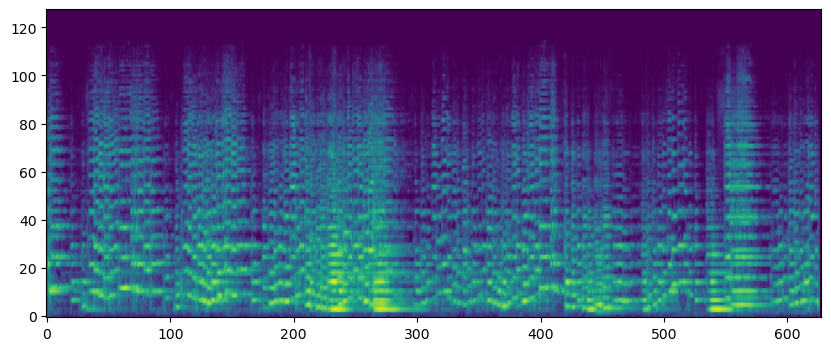

In [64]:
# --- TEST
idx_file = 100
with h5py.File(hdf5_audio_file, 'r') as hdf5_fid:
    print(audiofile_l[idx_file])
    audio_v = hdf5_fid[audiofile_l[idx_file]][:]
    sr_hz = hdf5_fid[audiofile_l[idx_file]].attrs['sr_hz']

data_m, time_sec_v = feature.f_get_lms(audio_v, sr_hz, param_lms)

plt.figure(figsize=(10,4))
print(data_m.shape)
plt.imshow(data_m, origin='lower', aspect='auto');

In [65]:
# --- TEST
feature.f_get_patches(T=250, L=64, S=32)

[{'start_frame': 0, 'end_frame': 64},
 {'start_frame': 32, 'end_frame': 96},
 {'start_frame': 64, 'end_frame': 128},
 {'start_frame': 96, 'end_frame': 160},
 {'start_frame': 128, 'end_frame': 192},
 {'start_frame': 160, 'end_frame': 224}]

### Create Dataset

In [66]:
from tqdm import tqdm

class GenreDataset(Dataset):
    """
    description
    """

    def __init__(self, hdf5_audio_file, pyjama_annot_file, do_train):

        with open(pyjama_annot_file, encoding = "utf-8") as json_fid: data_d = json.load(json_fid)
        entry_l = data_d['collection']['entry']
        
        #entry_l = entry_l[:1000] ############### TO REMOVE ####################
        
        self.labelname_dict_l = f_get_labelname_dict(data_d, annot_key)

        self.do_train = do_train
        if self.do_train:   entry_l = [entry_l[idx] for idx in range(len(entry_l)) if (idx % 5) != 0]
        else:               entry_l = [entry_l[idx] for idx in range(len(entry_l)) if (idx % 5) == 0]

        self.audio_file_l =  [entry['filepath'][0]['value'] for entry in entry_l]

        self.feature_d = {}
        self.patch_l = []
        
        with h5py.File(hdf5_audio_file, 'r') as audio_fid:
            for entry in tqdm(entry_l):
                audio_file= entry['filepath'][0]['value']

                if do_feature == 'waveform':
                    feat_value_m = audio_fid[audio_file][:].reshape(1,-1)
                    
                elif do_feature == 'lms':
                    feat_value_m, _ = feature.f_get_lms(audio_fid[audio_file][:], audio_fid[audio_file].attrs['sr_hz'], param_lms)
                
                idx_label = f_get_groundtruth_item(entry, annot_key, self.labelname_dict_l, problem)
                
                self.feature_d[audio_file] = {'X': torch.tensor(feat_value_m).float(), 'y': torch.tensor(idx_label)}
                
                localpatch_l = feature.f_get_patches(feat_value_m.shape[-1], param_patch.L_frame, param_patch.STEP_frame)
                for localpatch in localpatch_l:
                    self.patch_l.append({'audiofile': audio_file,
                                        'start_frame': localpatch['start_frame'],
                                        'end_frame': localpatch['end_frame'],
                                        })

    def __len__(self):
        return len(self.patch_l)

    def __getitem__(self, idx_patch):
        s = self.patch_l[idx_patch]['start_frame']
        e = self.patch_l[idx_patch]['end_frame']
        X = self.feature_d[ self.patch_l[idx_patch]['audiofile'] ]['X'][:,s:e]
        if do_feature == 'lms': X = X.unsqueeze(0) # --- add channel dimension
        y = self.feature_d[ self.patch_l[idx_patch]['audiofile'] ]['y'] # --- We suppose the same annotation for the whole file
        return {'X':X , 'y':y}
    
train_dataset = GenreDataset(hdf5_audio_file, pyjama_annot_file, do_train=True)
valid_dataset = GenreDataset(hdf5_audio_file, pyjama_annot_file, do_train=False)

100%|██████████| 212/212 [00:06<00:00, 32.75it/s]


In [67]:
# --- TEST
print(len(train_dataset))
print(train_dataset[0]['X'].shape)
print(train_dataset[0]['y'].shape)

15192
torch.Size([1, 128, 64])
torch.Size([50])


### Create Dataloader

In [68]:
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=param_model.batch_size, shuffle=True, num_workers=8, drop_last = True)
valid_dataloader = torch.utils.data.DataLoader(valid_dataset, batch_size=param_model.batch_size, shuffle=False, num_workers=8, drop_last = True)

In [69]:
# --- TEST
batch = next(iter(train_dataloader))
print(batch['X'].size())
print(batch['y'].size())

torch.Size([128, 1, 128, 64])
torch.Size([128, 50])


## Model

In [70]:
with open('config_autotagging.yaml', 'r') as fid: 
    cfg_dic = yaml.safe_load(fid)
config = munchify(cfg_dic)


class AutoTaggingModel(nn.Module):
    def __init__(self, config, current_input_dim):
        super(AutoTaggingModel, self).__init__()
        self.block_l = []
        for config_block in config.model.block_l:
            sequential_l = []
            for config_sequential in config_block.sequential_l:
                component_l = []
                for config_component in config_sequential.component_l:
                    module, current_input_dim = model_factory.f_parse_component(config_component[0], config_component[1], current_input_dim) 
                    component_l.append( module )
                sequential_l.append( nn.Sequential (*component_l) )
            self.block_l.append( nn.ModuleList(sequential_l) )
            self.model = nn.ModuleList(self.block_l)

    def forward(self, X, do_verbose=False):
        for idx_block, block in enumerate(self.model):
            for idx_sequential, sequential in enumerate(block):
                if do_verbose: print(f'{idx_block}/{idx_sequential}---------------------------------\n{sequential}\n> in: {X.size()}')
                X = sequential( X )
                if do_verbose: print(f'> out: {X.size()}')
        return X


if do_feature == 'waveform':
    m, C, T = 64, 1, 3200
    model = AutoTaggingModel(config, [m, C, T])
if do_feature == 'lms':
    m, C, H, W = 64, 1, 128, 64
    model = AutoTaggingModel(config, [m, C, H, W])

model = model.to(param_model.device)

In [50]:
# --- TEST
if do_feature == 'waveform':
    m, C, T = 64, 1, 3200

    #X = torch.randn(m, C, T).to(param_model.device)
    #print(model(X, True).size())
    
    torchsummary.summary(model, input_size=(C, T))

if do_feature == 'lms':
    m, C, H, W = 64, 1, 128, 64

    #X = torch.randn(m, C, H, W).to(param_model.device)
    #print(model(X, True).size())

    torchsummary.summary(model, input_size=(C, H, W))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
         LayerNorm-1           [-1, 1, 128, 64]          16,384
            Conv2d-2            [-1, 80, 1, 60]          51,280
         nnSqueeze-3               [-1, 80, 60]               0
         LayerNorm-4               [-1, 80, 60]           9,600
         LeakyReLU-5               [-1, 80, 60]               0
           Dropout-6               [-1, 80, 60]               0
            Conv1d-7               [-1, 60, 56]          24,060
         MaxPool1d-8               [-1, 60, 18]               0
         LayerNorm-9               [-1, 60, 18]           2,160
        LeakyReLU-10               [-1, 60, 18]               0
          Dropout-11               [-1, 60, 18]               0
           Conv1d-12               [-1, 60, 14]          18,060
        MaxPool1d-13                [-1, 60, 4]               0
        LayerNorm-14                [-1

### Test model

In [71]:
batch = next(iter(train_dataloader))
X = batch['X'].to(param_model.device)
y = batch['y'].to(param_model.device)
hat_y = model(X)
print(f'{X.size()} {y.size()} {hat_y.squeeze(1).size()}')


torch.Size([128, 1, 128, 64]) torch.Size([128, 50]) torch.Size([128, 50])


In [72]:
if problem=='multiclass': 
    nn.CrossEntropyLoss()(hat_y, y)
elif problem=='multilabel': 
    nn.BCEWithLogitsLoss(reduction='none')(hat_y.squeeze(1), y).size()

## Training using TorchLightning

### W&B configuration

### TorchLightning

In [73]:
def get_accuracy(hat_y, y):
    """ Manually compute accuracy """
    preds = torch.argmax(hat_y, dim=1)  # Get the predicted class (index of max logit)
    correct = (preds == y).float()  # Compare with ground truth and cast to float
    accuracy = correct.sum() / len(correct)  # Compute mean accuracy over the batch
    return accuracy

class AutoTaggingLigthing(pl.LightningModule):
    def __init__(self, in_model):
        super().__init__()
        self.model = in_model
        if problem=='multiclass': self.loss = nn.CrossEntropyLoss()
        elif problem=='multilabel': self.loss = nn.BCEWithLogitsLoss()

    def training_step(self, batch, batch_idx):
        hat_y = self.model(batch['X'])
        loss = self.loss(hat_y, batch['y'])

        self.log("train_loss", loss, prog_bar=True)
        if problem=='multiclass': 
            accuracy = get_accuracy(hat_y, batch['y'])
            self.log('train_acc', accuracy, prog_bar=True)

        return loss

    def validation_step(self, batch, batch_idx):
        hat_y = self.model(batch['X'])
        loss = self.loss(hat_y, batch['y'])
        
        self.log('val_loss', loss, prog_bar=True)
        if problem=='multiclass': 
            accuracy = get_accuracy(hat_y, batch['y'])
            self.log('val_acc', accuracy, prog_bar=True)

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), 0.001)
        return optimizer

### Training

In [74]:
my_lighting = AutoTaggingLigthing( model )
early_stop_callback = EarlyStopping(monitor="val_loss", patience=10, verbose=True, mode="min")
checkpoint_callback = ModelCheckpoint(monitor='val_loss', dirpath=param_lightning.dirpath, filename=param_lightning.filename, save_top_k=1, mode='min')
trainer = pl.Trainer(accelerator="gpu",  max_epochs = param_lightning.max_epochs, callbacks = [early_stop_callback, checkpoint_callback])
trainer.fit(model=my_lighting, train_dataloaders=train_dataloader, val_dataloaders=valid_dataloader)

/home/ids/gpeeters/anaconda3/envs/conda_gpeeters_2024/lib/python3.8/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/ids/gpeeters/anaconda3/envs/conda_gpeeters_202 ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/ids/gpeeters/anaconda3/envs/conda_gpeeters_2024/lib/python3.8/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:653: Checkpoint directory /home/ids/gpeeters/proj_tuto-ISMIR2024/code/my_model exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type              | Params
--------------------------------------------
0 | model | AutoTaggingModel  | 170 K 
1 | loss  | BCEWithLogitsLoss | 0     
---------------------------------------

Epoch 0: 100%|██████████| 118/118 [00:04<00:00, 28.44it/s, v_num=13, train_loss=0.204, val_loss=0.190]

Metric val_loss improved. New best score: 0.190


Epoch 1: 100%|██████████| 118/118 [00:06<00:00, 16.98it/s, v_num=13, train_loss=0.176, val_loss=0.175]

Metric val_loss improved by 0.016 >= min_delta = 0.0. New best score: 0.175


Epoch 2: 100%|██████████| 118/118 [00:07<00:00, 16.77it/s, v_num=13, train_loss=0.157, val_loss=0.170]

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.170


Epoch 3: 100%|██████████| 118/118 [00:06<00:00, 17.30it/s, v_num=13, train_loss=0.142, val_loss=0.169]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.169


Epoch 13: 100%|██████████| 118/118 [00:06<00:00, 17.94it/s, v_num=13, train_loss=0.0767, val_loss=0.220]

Monitored metric val_loss did not improve in the last 10 records. Best score: 0.169. Signaling Trainer to stop.


Epoch 13: 100%|██████████| 118/118 [00:06<00:00, 17.94it/s, v_num=13, train_loss=0.0767, val_loss=0.220]


## Evaluation

### Load best model

In [75]:
best_model_path = checkpoint_callback.best_model_path
#best_model_path = 'my_model/best_model.ckpt'
print(f"Best model saved at: {best_model_path}")
my_lighting = AutoTaggingLigthing.load_from_checkpoint(best_model_path, in_model=model)

print( type(model) )
print( type(my_lighting) )
print( type(my_lighting.model) )

model = my_lighting.model
model.to(param_model.device)

Best model saved at: /home/ids/gpeeters/proj_tuto-ISMIR2024/code/my_model/best_model-v10.ckpt
<class '__main__.AutoTaggingModel'>
<class '__main__.AutoTaggingLigthing'>
<class '__main__.AutoTaggingModel'>


AutoTaggingModel(
  (model): ModuleList(
    (0): ModuleList(
      (0): Sequential(
        (0): LayerNorm((128, 64), eps=1e-05, elementwise_affine=True)
        (1): Conv2d(1, 80, kernel_size=(128, 5), stride=(1, 1), padding=valid)
        (2): nnSqueeze()
        (3): LayerNorm((80, 60), eps=1e-05, elementwise_affine=True)
        (4): LeakyReLU(negative_slope=0.01)
        (5): Dropout(p=0, inplace=False)
      )
      (1): Sequential(
        (0): Conv1d(80, 60, kernel_size=(5,), stride=(1,))
        (1): MaxPool1d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
        (2): LayerNorm((60, 18), eps=1e-05, elementwise_affine=True)
        (3): LeakyReLU(negative_slope=0.01)
        (4): Dropout(p=0, inplace=False)
      )
      (2): Sequential(
        (0): Conv1d(60, 60, kernel_size=(5,), stride=(1,))
        (1): MaxPool1d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
        (2): LayerNorm((60, 4), eps=1e-05, elementwise_affine=True)
        (

### Multi-class: performance measures

(3712,)
(3712,)
{'0': {'f1-score': 0.7124260355029586,
       'precision': 0.6473118279569893,
       'recall': 0.7921052631578948,
       'support': 380.0},
 '1': {'f1-score': 0.8724279835390947,
       'precision': 0.9111747851002865,
       'recall': 0.8368421052631579,
       'support': 380.0},
 '2': {'f1-score': 0.5639614855570839,
       'precision': 0.590778097982709,
       'recall': 0.5394736842105263,
       'support': 380.0},
 '3': {'f1-score': 0.6947960618846695,
       'precision': 0.7462235649546828,
       'recall': 0.65,
       'support': 380.0},
 '4': {'f1-score': 0.6763717805151176,
       'precision': 0.5886939571150097,
       'recall': 0.7947368421052632,
       'support': 380.0},
 '5': {'f1-score': 0.7017543859649122,
       'precision': 0.7202216066481995,
       'recall': 0.6842105263157895,
       'support': 380.0},
 '6': {'f1-score': 0.8277634961439587,
       'precision': 0.8090452261306532,
       'recall': 0.8473684210526315,
       'support': 380.0},
 '7':

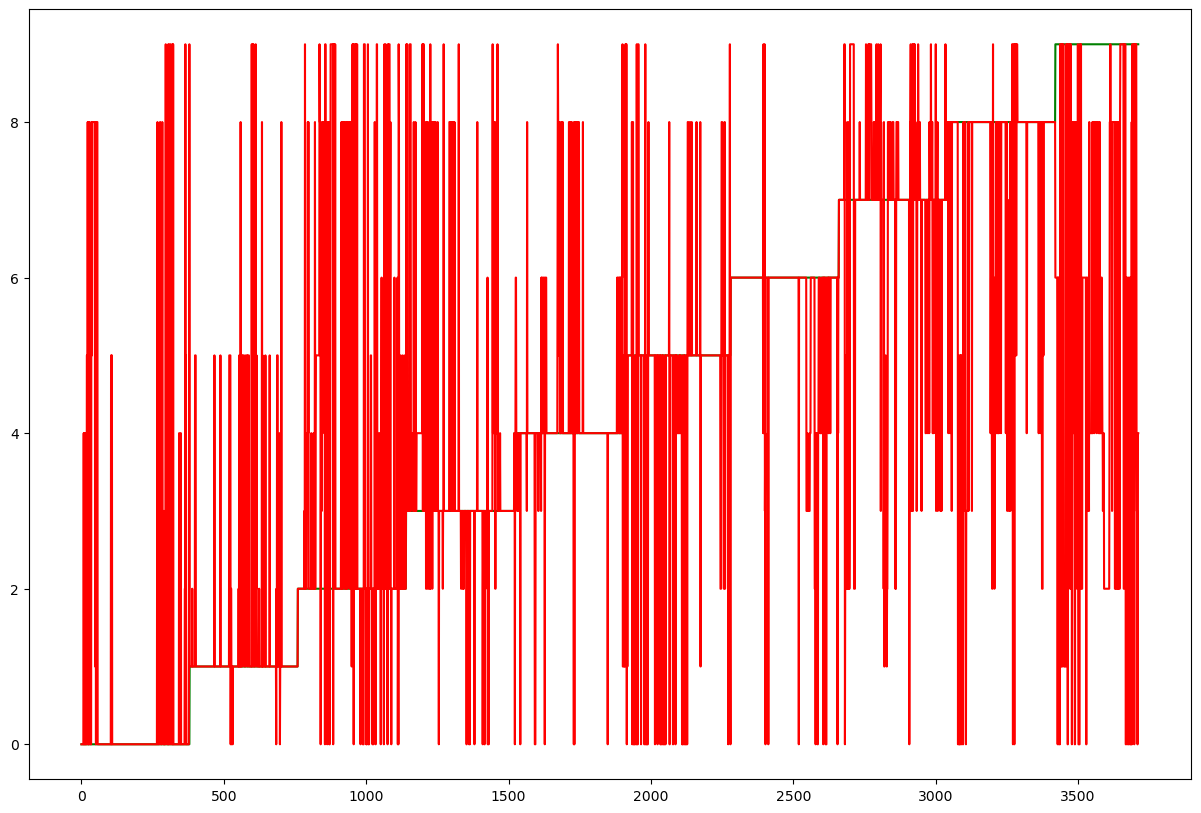

In [ ]:
y_idx_l = []
hat_y_idx_l = []
for batch in valid_dataloader:
    hat_y_prob = model(batch['X'].to(param_model.device))
    y_idx_l.append(batch['y'].numpy())
    hat_y_idx_l.append(np.argmax(hat_y_prob.detach().cpu().numpy(), axis=1))
y_idx_v = np.concatenate(y_idx_l)
hat_y_idx_v = np.concatenate(hat_y_idx_l)
print(y_idx_v.shape)
print(hat_y_idx_v.shape)

plt.plot(y_idx_v, 'g')
plt.plot(hat_y_idx_v, 'r')

from sklearn.metrics import classification_report, confusion_matrix
classification_reports = classification_report(y_true=y_idx_v, y_pred=hat_y_idx_v, output_dict=True, zero_division=0)
pp.pprint(classification_reports)
cm = confusion_matrix(y_true=y_idx_v, y_pred=hat_y_idx_v)
print(cm)
# --- accuracy: np.sum(np.diag(cm))/np.sum(cm)
# --- recall: for c in range(10): print(cm[c,c]/np.sum(cm[c,:]))

### Multi-label performances

In [83]:
print( y_ohe_m.shape )
print( len(set(np.argmax(y_ohe_m, axis=1))) )

(3712, 50)
38


In [76]:
y_ohe_l = []
y_prob_l = []
for batch in valid_dataloader:
    y_prob = F.sigmoid(model(batch['X'].to(param_model.device)))
    if problem=='multiclass':       y_ohe_l.append(F.one_hot(batch['y'], 10).numpy())
    elif problem=='multilabel':     y_ohe_l.append(batch['y'].numpy())
    y_prob_l.append(y_prob.detach().cpu().numpy())
y_ohe_m = np.concatenate(y_ohe_l) # --- convert list to array
y_prob_m = np.concatenate(y_prob_l)

from sklearn.metrics import roc_auc_score, average_precision_score
auc = roc_auc_score(y_true=y_ohe_m, y_score=y_prob_m, average="macro")
print(f'auc: {auc}')
average_precision = average_precision_score(y_true=y_ohe_m, y_score=y_prob_m, average="macro")
print(f'average_precision: {average_precision}')

ValueError: Only one class present in y_true. ROC AUC score is not defined in that case.

### Illustration: tag-o-gram

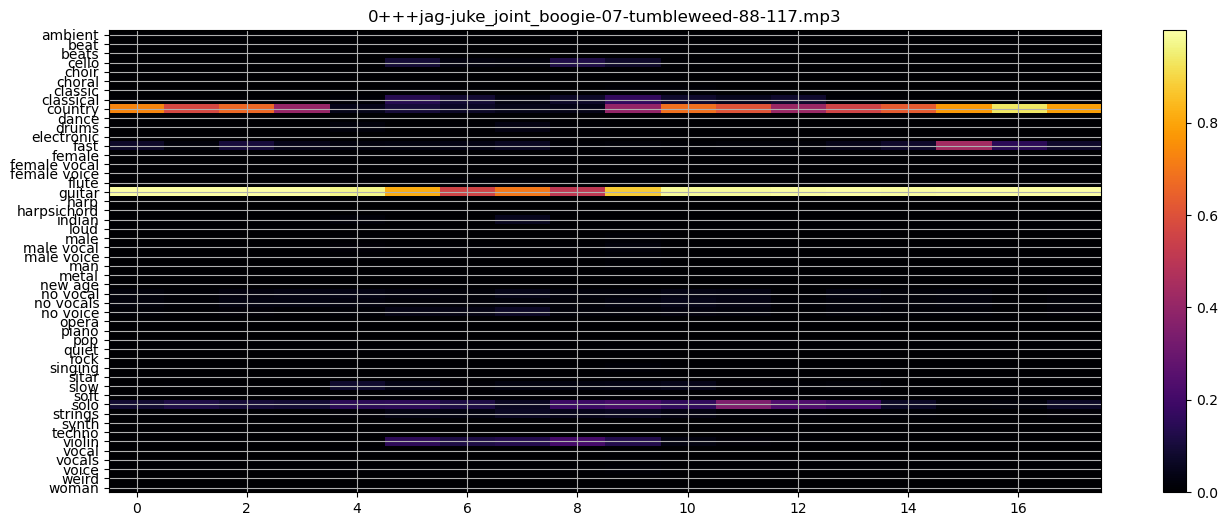

In [59]:
def F_tag_o_gram(audio_v, sr_hz):
    """
    """
    # --- Compute the audio features
    if do_feature == 'waveform':    feat_value_m = audio_v.reshape(1,-1)
    elif do_feature == 'lms':       feat_value_m, _ = feature.f_get_lms(audio_v, sr_hz, param_lms)
                
    # --- Split matrix into patches
    nb_frame = feat_value_m.shape[1]
    patch_info_l = feature.f_get_patches(feat_value_m.shape[-1], param_patch.L_frame, param_patch.STEP_frame)
    nb_patch = len(patch_info_l)
    data_3m = np.zeros((nb_patch, feat_value_m.shape[0], param_patch.L_frame))
    for idx in range(nb_patch):
        data_3m[idx, :, :] = feat_value_m[:, patch_info_l[idx]['start_frame']:patch_info_l[idx]['end_frame']]

    # --- Convert numpy to torch tensor
    X = torch.from_numpy(data_3m).float().to(param_model.device)
    if do_feature == 'lms': X = X.unsqueeze(1) # --- add channel dimension

    # --- Get prediction from model
    model.eval()
    y_hat = model(X)
    if problem=='multiclass':
        predicted = F.softmax(y_hat, dim=1)
    elif problem=='multilabel':
        predicted = F.sigmoid(y_hat)
    # --- Convert from torch tensor to numpy
    y_hat_m = predicted.cpu().detach().numpy()

    fig, axes = plt.subplots(1, 1, figsize=(16, 6))
    im = axes.imshow(y_hat_m.T, aspect='auto', interpolation=None, cmap=plt.get_cmap('inferno'))
    axes.set_yticks(np.arange(0,len(valid_dataset.labelname_dict_l)))
    axes.set_yticklabels(valid_dataset.labelname_dict_l)
    axes.grid(True)
    fig.colorbar(im, orientation='vertical')

    return


# ---------------------------------------------
# ---------------------------------------------
# ---------------------------------------------
audio_file= valid_dataset.audio_file_l[100]

with h5py.File(hdf5_audio_file, 'r') as audio_fid:
    audio_value_v = audio_fid[audio_file][:]
    audio_sr_hz = audio_fid[audio_file].attrs['sr_hz']
F_tag_o_gram(audio_value_v, audio_sr_hz)
plt.title(audio_file)
IPython.display.Audio(data=audio_value_v, rate=audio_sr_hz)

### Display learned filters Conv1D

In [ ]:
#weight = model.frontend[1].weight # --- conv1D
#weight = model.frontend[1].filters # --- SincNet
named_modules_dict = dict(model.named_modules())
#weight = named_modules_dict['model.0'][1].weight
weight = named_modules_dict['model.0'][1].filters

AttributeError: 'Sequential' object has no attribute 'filters'

In [ ]:
plt.figure(figsize=(10,10))
nb_filter = weight.size()[0]
nb_filter = 40
for num_filter in range(nb_filter):
    value = weight[num_filter,:,:].squeeze().detach().cpu() # --- conv1D
    plt.subplot(nb_filter, 2, 2*num_filter+1)
    plt.plot( value ); plt.title(num_filter)
    plt.subplot(nb_filter, 2, 2*num_filter+2)
    plt.plot(np.abs(np.fft.rfft(value)) ); plt.title(num_filter)

### Display learned filters SincNet